Code cleaup. Need to 
1. remove repeated sentences due to vtt formatting
2. some words are concatenated together (helloBut--> hello But, swimming in a pool.We--> swimming in a pool. We)

In [1]:
import glob
import json
import regex as re
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus.reader import *
import nltk
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
import seaborn as sns

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
test=['pain', 'and', 'agony', 'pain and agony']
bad_test=['bad', 'worse', 'worst']
emojis=['^^', ':D', 'XD', ':p']
post_twenty_fourteen=['pog', 'af', 'smh', 'acquihire', 'ffs']

def sia_sentiment(listOfWords):
    for sentence in listOfWords:
        sid = SIA()
        print(sentence)
        ss = sid.polarity_scores(sentence)
        for k in sorted(ss):
            print('{0}: {1}, '.format(k, ss[k]), end='')
        print()

sia_sentiment(post_twenty_fourteen)

pog
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
af
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
smh
compound: -0.3182, neg: 1.0, neu: 0.0, pos: 0.0, 
acquihire
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
ffs
compound: -0.5859, neg: 1.0, neu: 0.0, pos: 0.0, 


In [3]:
with open('../channelHolisticInfo.json', 'r') as j:
    channelHolisticInfo = json.loads(j.read())
channelHolisticInfoDf = pd.DataFrame.from_dict(channelHolisticInfo)
channelHolisticInfoDf.drop('60', inplace = True)
channelHolisticInfoDf.index = range(len(channelHolisticInfoDf))
channelHolisticInfoDf

,channelName,channelId,daysLiveAsOfLaunch,daysSinceFirstVideo,description,viewCount,subscriberCount,videoCount,firstUploadDate,subscribersPerYearSinceFirstUpload,viewCountPerYearSinceFirstUpload
0,TJ Toons,UCnsem444vdU1HhS0mb2wwTA,3841,1276,Tellin my stories for fun,40741423,503000,15,2018-06-27T12:10:25Z,143883.228840,1.165409e+07
1,Alex's Corner,UCnbtlei4RJMHWSUq4LKn_SQ,1530,1528,Welcome to my corner~ \n\nThis is where I ramb...,27822141,648000,25,2017-10-18T07:43:58Z,154790.575916,6.645996e+06
2,RushLight Invader,UC9i7x4EzTBlNvslu1wWEB8Q,3311,3251,"Hello, I'm RushLight Invader! I make animation...",20078925,276000,46,2013-01-29T04:22:45Z,30987.388496,2.254324e+06
3,ChillyPanda,UC1nM46_BMKq4vd4jmd6iMHA,2075,2036,"Hey guys, it's Chilly~\n\nI honestly don't kno...",10232784,191000,51,2016-05-27T18:48:49Z,34241.159136,1.834463e+06
4,Recreyo,UCMNxwlfY6P5Rm40QOp8Hqsg,581,559,,42863332,340000,79,2020-06-12T19:00:07Z,222003.577818,2.798769e+07
...,...,...,...,...,...,...,...,...,...,...,...
56,Jacadamia,UCHw-JjzU80GKrGJwI1Uf1OQ,2388,1966,Nut-based variety animator :3\n\n(This channel...,2301477,80400,23,2016-08-06T05:04:56Z,14926.754832,4.272834e+05
57,grgikau,UCDEaY2XwwfKomQAJgGfehWw,3297,2012,"Hello! I'm grgikau. I'm an animator, and here ...",410169,12300,16,2016-06-21T04:03:05Z,2231.361829,7.440939e+04
58,Laddi,UCI-92EMS3ZJ11gz-S_oyaSA,1981,1950,I explained that thing bad haha funny time\n-\...,3299900,187000,16,2016-08-22T10:02:48Z,35002.564103,6.176736e+05
59,The French Pineapple,UC7Mk9RmlKT_x8FAsMOJn1cg,3330,1930,Bonjour,1632937,34700,25,2016-09-11T14:50:21Z,6562.435233,3.088197e+05


In [4]:
LIST_OF_CHANNEL_IDS = channelHolisticInfoDf['channelId'].tolist()
LIST_OF_CHANNEL_NAMES = channelHolisticInfoDf['channelName'].tolist()
LIST_OF_VIDEO_COUNT = channelHolisticInfoDf['videoCount'].tolist()
print(len(LIST_OF_VIDEO_COUNT), len(LIST_OF_VIDEO_COUNT), len(LIST_OF_VIDEO_COUNT))

61 61 61


In [5]:
def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        duplicatedLinesList = []
        for index in range(len(strippedLines)):
            duplicatedLinesList.append(strippedLines[index])
    return [i for n, i in enumerate(duplicatedLinesList) if i not in duplicatedLinesList[:n]]
# print(generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt"))

def generateListOfWords(listOfSentences):
    all_stopwords = list(stopwords.words('english'))
    cleanedListOfWords = []
    for words in listOfSentences:
        word = re.split('[?."(),!) ]', words)
        for wo in word:
            if wo !='' and wo not in all_stopwords:
                cleanedListOfWords.append(wo)
    return cleanedListOfWords

def flattenList(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

#wordCloud[channelId] = all words from all .txt files with no stopwords
#sentenceCloud[channelId] = all sentences from all .txt files.

wordCloud = {}
sentenceCloud = {}
for channelId in LIST_OF_CHANNEL_IDS:
    listOfSentences = []
    listOfWords = []
    print(channelId, "has ", len(glob.glob(channelId+"/txt/*.txt")), "files to process.")
    for txtFilePath in glob.glob(channelId+"/txt/*.txt"):
        listOfSentences.append(generateListOfSentences(txtFilePath))
    flattenedListOfSentences = flattenList(listOfSentences) #<--
    flattendListOfWords = generateListOfWords(flattenedListOfSentences)

    sentenceCloud[channelId.split('/')[0]] = flattenedListOfSentences
    wordCloud[channelId.split('/')[0]] = flattendListOfWords
    print(channelId.split('/')[0], ": ", len(flattenedListOfSentences), "sentences total")
    print(channelId.split('/')[0], ": ", len(flattendListOfWords), "words total")

    # with open(channelId.split('/')[0]+"_wordCloud.txt", 'w') as f:
    #     json.dump(flattendListOfWords, f)
    # with open(channelId.split('/')[0]+"_sentenceCloud.txt", 'w') as f:
    #     json.dump(flattenedListOfSentences, f)

UCnsem444vdU1HhS0mb2wwTA has  15 files to process.
UCnsem444vdU1HhS0mb2wwTA :  2917 sentences total
UCnsem444vdU1HhS0mb2wwTA :  10302 words total
UCnbtlei4RJMHWSUq4LKn_SQ has  24 files to process.
UCnbtlei4RJMHWSUq4LKn_SQ :  4517 sentences total
UCnbtlei4RJMHWSUq4LKn_SQ :  16332 words total
UC9i7x4EzTBlNvslu1wWEB8Q has  39 files to process.
UC9i7x4EzTBlNvslu1wWEB8Q :  6017 sentences total
UC9i7x4EzTBlNvslu1wWEB8Q :  21550 words total
UC1nM46_BMKq4vd4jmd6iMHA has  49 files to process.
UC1nM46_BMKq4vd4jmd6iMHA :  10639 sentences total
UC1nM46_BMKq4vd4jmd6iMHA :  36558 words total
UCMNxwlfY6P5Rm40QOp8Hqsg has  75 files to process.
UCMNxwlfY6P5Rm40QOp8Hqsg :  30915 sentences total
UCMNxwlfY6P5Rm40QOp8Hqsg :  101127 words total
UCsDmESjqNPukDmVnuneLrqw has  298 files to process.
UCsDmESjqNPukDmVnuneLrqw :  35438 sentences total
UCsDmESjqNPukDmVnuneLrqw :  155499 words total
UCY6Ij8zOds0WJEeqCLOnqOQ has  250 files to process.
UCY6Ij8zOds0WJEeqCLOnqOQ :  81861 sentences total
UCY6Ij8zOds0WJEe

# Holistically

61


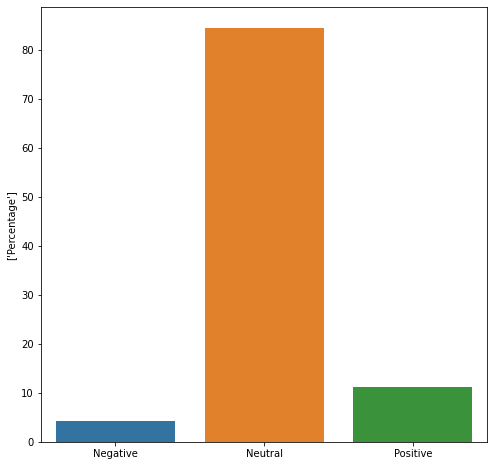

,neg,neu,pos,compound,words,label
0,0.0,0.0,1.0,0.2500,alright,1
1,0.0,1.0,0.0,0.0000,got,0
2,0.0,0.0,1.0,0.4215,nice,1
3,0.0,0.0,1.0,0.4404,easy,1
4,0.0,1.0,0.0,0.0000,hmm,0


In [15]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

print(len(wordCloud.keys()))
for channelId in LIST_OF_CHANNEL_IDS:
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

In [16]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,words,label
0,0.0,0.0,1.0,0.2500,alright,1
2,0.0,0.0,1.0,0.4215,nice,1
3,0.0,0.0,1.0,0.4404,easy,1
10,0.0,0.0,1.0,0.4939,hand,1
12,0.0,0.0,1.0,0.3182,please,1


In [17]:
print(df_positive_negative.label.value_counts())

 1    335729
-1    125983
Name: label, dtype: int64


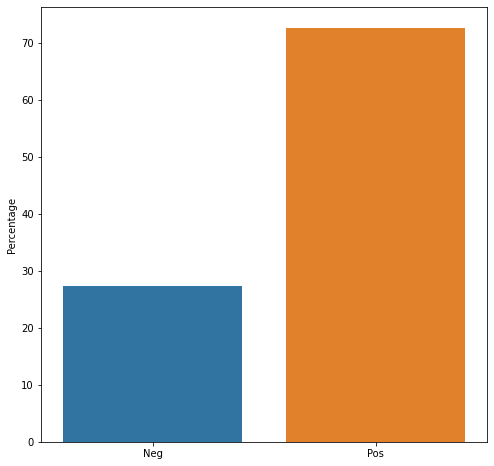

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

Basically, compared to redditors, animation youtubers are more 'positive'.

Which is honestly not that surprising. Redditors are among the most realistic people out there and youtubers are generally out there to 'entertain'. 

# By Channel by words

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
channelId_to_df = {}
sia = SIA()
for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_df[channelId] = df
df[150:200]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generateWordCloud(pos_words_str, neg_words_str):
    wordcloud_positive = WordCloud(background_color='white').generate(pos_words_str)
    wordcloud_negative = WordCloud().generate(neg_words_str)

    plt.imshow(wordcloud_positive, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.imshow(wordcloud_negative, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_df[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].words)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].words)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
print(scores)

In [ ]:
sorted_channelName_to_scores = dict(sorted(scores.items(), key=lambda item: item[1]))
sctsdf = pd.DataFrame.from_dict({'channelName':sorted_channelName_to_scores.keys(), 'scores': sorted_channelName_to_scores.values()})
sctsdf

In [ ]:
%matplotlib widget

ValueError: x and y must have same first dimension, but have shapes (60,) and (61,)

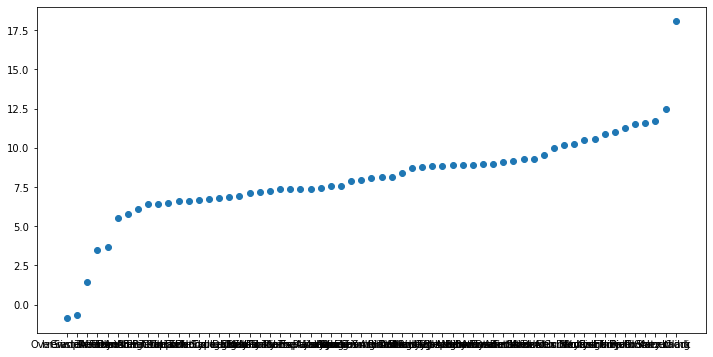

In [19]:
x_name = "Channel Name"
y_name = "Positivity"
tooltip_name = "positivity value"

x= sctsdf['channelName']
y= sctsdf['scores'] * 100
tt = sctsdf['scores']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
avg_score=sum(scores.values())/len(LIST_OF_CHANNEL_NAMES)

mean_x=np.arange(0,60,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()


# By channel and sentences

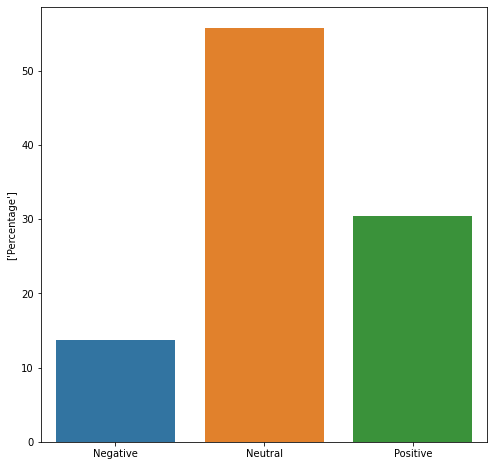

,neg,neu,pos,compound,sentence,label
0,0.0,0.329,0.671,0.7992,alright you got this nice and easy,1
1,0.0,0.714,0.286,0.4939,hmm oh my gosh he's using his right hand,1
2,0.0,1.000,0.000,0.0000,to eat,0
3,0.0,0.753,0.247,0.3182,please put your hands up where i can see,1
4,0.0,1.000,0.000,0.0000,him wait what,0


In [6]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for channelId in LIST_OF_CHANNEL_IDS:
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

# By channel by sentences

In [24]:
sentenceCloud

{'UCnsem444vdU1HhS0mb2wwTA': ['alright you got this nice and easy',
  "hmm oh my gosh he's using his right hand",
  'to eat',
  'please put your hands up where i can see',
  'him wait what',
  'according to sector 420 of the u.s',
  'federal lefty regulations',
  'you have directly violated the law by',
  'choosing to use your right hand for any',
  'form of common conduct in this case',
  "eating which means you're coming with us",
  'no wait officer please it was just one',
  'time please',
  'my sushi handiness a word used to',
  'describe',
  'a better faster or precise performance',
  'or an',
  "individual's preferred use of a hand",
  'also known as the dominant hand in which',
  'case is my right',
  "because i'm always right being a righty",
  "all my life i always wonder what it'd be",
  'like to be',
  'a left-handed person like what actually',
  'goes through their mind are they',
  'actually',
  'smarter than right-handed people like',
  'google says or how it feels like t

In [7]:
#General sentiment by words spoken by youtubers
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
channelId_to_sentencedf = {}

for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_sentencedf[channelId] = df
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1


In [8]:
from IPython.display import display

for channelId in LIST_OF_CHANNEL_IDS[8:12]:
    display(channelId_to_sentencedf[channelId][200:210])

,neg,neu,pos,compound,sentence
200,0.169,0.831,0.000,-0.0572,taking notes look I don't want to give
201,0.139,0.567,0.295,0.3352,them too much credit I don't want to
202,0.000,0.765,0.235,0.2846,encourage theft at any scale but the way
203,0.000,0.759,0.241,0.2263,this robbery took place is straight out
204,0.381,0.619,0.000,-0.5719,of a fast and furious movie according to
205,0.000,1.000,0.000,0.0000,Jeffrey the launch of Blue Blood was so
206,0.000,0.693,0.307,0.4767,ambitious and so large in scope that he
207,0.000,1.000,0.000,0.0000,had to spread out the units throughout
208,0.000,1.000,0.000,0.0000,his multiple warehouses to keep them
209,0.000,0.625,0.375,0.3400,secure we're talking over 1 million


,neg,neu,pos,compound,sentence
200,0.140,0.750,0.110,-0.1531,"I was just freaking karate chop that person's arm out of the way. Yeah, people thought I was a psychopath"
201,0.112,0.727,0.161,0.2235,But it wasn't my fault okay? When we left Middle school and started high school
202,0.000,1.000,0.000,0.0000,"I don't know how he did it, but somehow. He was able to make the acronym milf which stands for well... You can look it up"
203,0.000,1.000,0.000,0.0000,Become a very commonly used phrase in our school
204,0.000,1.000,0.000,0.0000,he would make all kinds of variations of the word a desk would become a dilf a
205,0.000,1.000,0.000,0.0000,Pencil would become a pencilf he even called me bilfy at one point
206,0.081,0.812,0.107,0.1779,There was no word in the English dictionary that was safe sooner or later everyone who knew shimada-san which was most people in school
207,0.000,0.690,0.310,0.7351,"He was a pretty popular guy, just started milfing up their sentences dang. I got really milfed by that test yesterday"
208,0.000,1.000,0.000,0.0000,"Hey, do you have any papilf? I can borrof are you going to prilf this year? Oh?"
209,0.000,1.000,0.000,0.0000,"What, prilf?"


,neg,neu,pos,compound,sentence
200,0.0,1.000,0.000,0.0000,replacement cartridges are sent for a
201,0.0,1.000,0.000,0.0000,few bucks a month we are talking about
202,0.0,1.000,0.000,0.0000,Razer cartridges again but I did for a
203,0.0,0.676,0.324,0.3400,second get excited that the butt-wipes
204,0.0,1.000,0.000,0.0000,came in a fully automatic magazine at
205,0.0,0.722,0.278,0.4019,any rate while they clearly need me on
206,0.0,1.000,0.000,0.0000,R&amp;D I have found my entire bathroom
207,0.0,1.000,0.000,0.0000,experience to actually be much more
208,0.0,1.000,0.000,0.0000,convenient because I don't have to
209,0.0,1.000,0.000,0.0000,remember to buy the little things I


,neg,neu,pos,compound,sentence
200,0.000,0.686,0.314,0.4939,hand I'm sponsored by Red Bull you know
201,0.000,0.619,0.381,0.5106,yeah go get a man ah all right well it
202,0.000,0.706,0.294,0.3612,seems like one of my teammates knows
203,0.000,1.000,0.000,0.0000,what they're I am never gonna level up
204,0.157,0.843,0.000,-0.0772,am i hey dude I'm sorry man I can't find
205,0.220,0.780,0.000,-0.3071,the enemy flag on this map but but we're
206,0.000,0.690,0.310,0.2023,playing team deathmatch wait a minute
207,0.485,0.515,0.000,-0.6908,that our team just get a kill
208,0.220,0.600,0.180,-0.1027,did the afk guy start playing no then
209,0.000,1.000,0.000,0.0000,then who was that man I'm never gonna


In [9]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,sentence,label
4,0.000,0.476,0.524,0.2960,"Yeah, I got nothing.",1
5,0.203,0.797,0.000,-0.3724,"In primary school, I didn't have any friends until the third grade.",-1
7,0.613,0.387,0.000,-0.5795,"No, not girl friends, girlfriends.",-1
8,0.000,0.761,0.239,0.2960,"Yeah, little Sultan was quite the hormonal monster.",1
9,0.000,0.601,0.399,0.8383,I really don't know why I was so interested in love at the age of five.,1


In [20]:
print(df_positive_negative.label.value_counts())

 1    335729
-1    125983
Name: label, dtype: int64


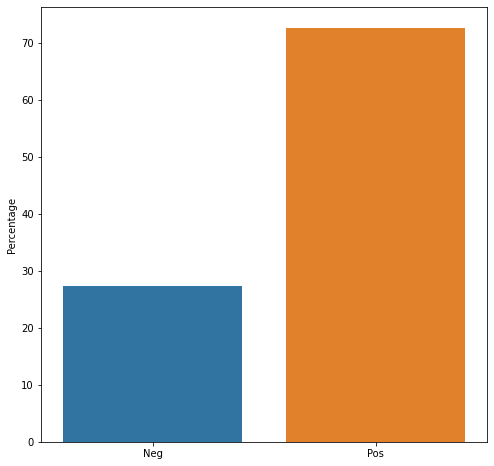

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

In [12]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_sentencedf[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].sentence)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].sentence)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq
    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)
    scores[channelId] = sum(target_df['compound'])/len(target_df)

print(len(scores), len(LIST_OF_CHANNEL_NAMES))

channelName_to_scores = {}
for i in range(0, len(LIST_OF_CHANNEL_NAMES)):
    channelName_to_scores[LIST_OF_CHANNEL_NAMES[i]] = list(scores.values())[i]

avg_score=sum(channelName_to_scores.values())/len(LIST_OF_CHANNEL_NAMES)
print("avg score =", avg_score)
print(channelName_to_scores)
print(sorted(channelName_to_scores.items(), key=lambda item: item[1]))

61 61
avg score = 0.0802744507314654
{'TJ Toons': 0.07251316420980443, "Alex's Corner": 0.09557075492583561, 'RushLight Invader': 0.08885047365796897, 'ChillyPanda': 0.07124994830341222, 'Recreyo': 0.03514642083131214, 'Alex Clark': 0.12511905017212815, 'Alex Meyers': 0.101710173342626, 'WowRightMeow': 0.08816854174131132, 'Andrei Terbea': 0.06099520863081154, 'Billy But Better': 0.08979263685427905, 'Casually Explained': 0.07362420842944017, 'CircleToonsHD': 0.07858606456165129, 'CurtRichy': 0.08384791048467052, 'CypherDen': 0.06808188185542463, 'Daidus': 0.06898366486850935, 'DanPlan': 0.05497511187019755, 'Domics': 0.10238580477972715, 'Emirichu': 0.11027874248446, 'EroldStory': 0.11507509659290606, 'GradeAUnderA': 0.014606097560975638, 'GetMadz': 0.09165491091822814, 'GingerPale': 0.10900744269127717, 'Ice Cream Sandwich': 0.0910426470588234, 'illymation': 0.07580338454687165, 'Ivan Animated': 0.08914942616679404, 'Jaiden Animations': 0.08062958149207235, 'Let Me Explain Studios': 

In [13]:
sorted_channelName_to_scores = dict(sorted(channelName_to_scores.items(), key=lambda item: item[1]))
sctsdf = pd.DataFrame.from_dict({'channelName':sorted_channelName_to_scores.keys(), 'scores': sorted_channelName_to_scores.values()})
sctsdf

,channelName,scores
0,OverSimplified,-0.008490
1,brewstewfilms,-0.006457
2,GradeAUnderA,0.014606
3,Recreyo,0.035146
4,Tabbes,0.037002
...,...,...
56,EroldStory,0.115075
57,LukeOrSomething,0.116148
58,Katzun,0.116922
59,Alex Clark,0.125119


In [15]:
%matplotlib widget


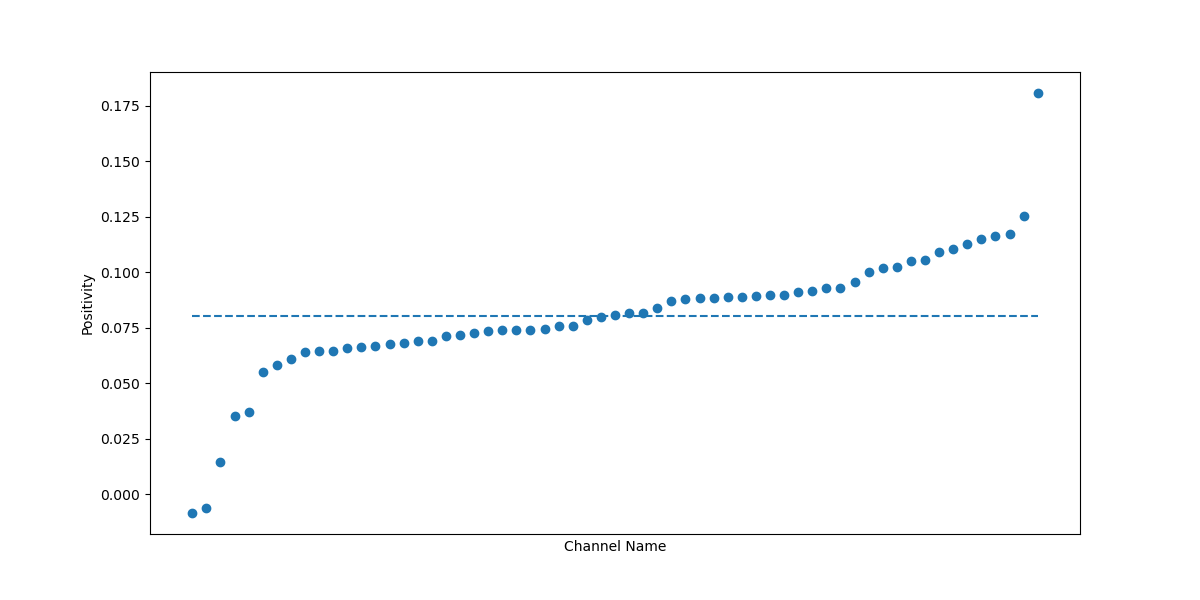

In [16]:
x_name = "Channel Name"
y_name = "Positivity"
tooltip_name = "positivity value"

x= sctsdf['channelName']
y= sctsdf['scores']
tt = sctsdf['scores']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
mean_x=np.arange(0,61,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()


In [18]:
num_of_files = []
for channelId in LIST_OF_CHANNEL_IDS:
    num_of_files.append(len(os.listdir(channelId+"/txt/")))

cntvdf = pd.DataFrame.from_dict({'channelName':LIST_OF_CHANNEL_NAMES, 'number of transcripts collected': num_of_files, 'number of vids': LIST_OF_VIDEO_COUNT})

cntvdf

,channelName,number of transcripts collected,number of vids
0,TJ Toons,15,15
1,Alex's Corner,24,25
2,RushLight Invader,39,46
3,ChillyPanda,49,51
4,Recreyo,75,79
...,...,...,...
56,Jacadamia,19,23
57,grgikau,15,16
58,Laddi,15,16
59,The French Pineapple,23,25


In [19]:
representation = sum(cntvdf['number of transcripts collected'])/sum(cntvdf['number of vids'])
print(representation)

0.836606291706387


In [23]:
#https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
subsPerYearSinceFirstUpload = channelHolisticInfoDf['subscribersPerYearSinceFirstUpload']

In [24]:
zipped = zip(channelHolisticInfoDf.channelName, channelHolisticInfoDf.subscribersPerYearSinceFirstUpload)
sorted_channelName_to_rescaledSubs = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
sctrs = pd.DataFrame.from_dict({'channelName': sorted_channelName_to_rescaledSubs.keys(), 'rescaledSubCount': sorted_channelName_to_rescaledSubs.values()})
sctrs

,channelName,rescaledSubCount
0,Wengsome,4.084054e+02
1,Donimation Studios,7.741079e+02
2,grgikau,2.231362e+03
3,uToonz,2.367358e+03
4,8 Bit Ultra,3.506715e+03
...,...,...
56,SomeThingElseYT,7.761601e+05
57,Domics,7.929678e+05
58,OverSimplified,1.116243e+06
59,Jaiden Animations,1.441144e+06


[6.012260321769536, 6.65171122691717, 7.71036736372337, 7.769529755002809, 8.162434945447261, 8.78911703761851, 9.539041978994295, 9.610910508042437, 10.0898598352636, 10.341335577977873, 10.441183682940846, 10.463176597861423, 10.669727797509701, 10.720428950442738, 10.87323686293505, 10.90325152718061, 11.037071004812299, 11.15436283760168, 11.211113744870469, 11.348197391358882, 11.412091000727418, 11.631331359569202, 11.78838667271183, 11.792469627503644, 11.843503068751557, 11.863390524971322, 11.876757338759633, 11.949828359190438, 12.22584953076548, 12.226786410507083, 12.303196457084118, 12.307662705565829, 12.310448777019737, 12.317236927057637, 12.319018327455762, 12.412021654110182, 12.421418886384352, 12.526980365610275, 12.559512180366278, 12.575005991883158, 12.708218735576441, 12.77788921743858, 12.81382549167171, 12.827952991364088, 12.889865106530289, 12.906213704833531, 12.910748141591602, 12.956471639106267, 13.010602157154551, 13.059269770095614, 13.07467767555555, 

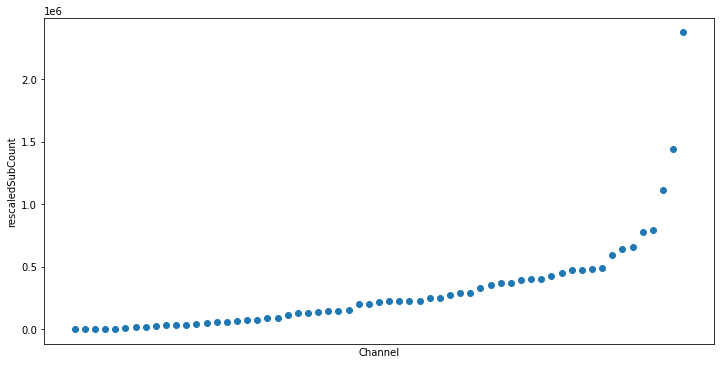

In [25]:
import math
x_name = "Channel"
y_name = "rescaledSubCount"
tooltip_name = "subCountPerYearSinceFirstUpload"

x= sctrs['channelName']
y= sctrs['rescaledSubCount']
y_log = [math.log(i) for i in sctrs['rescaledSubCount']]
print(y_log)
tt = sctrs['rescaledSubCount']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
# Plot the average line
mean_x=np.arange(0,56,1)
mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
# mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

61 61 61


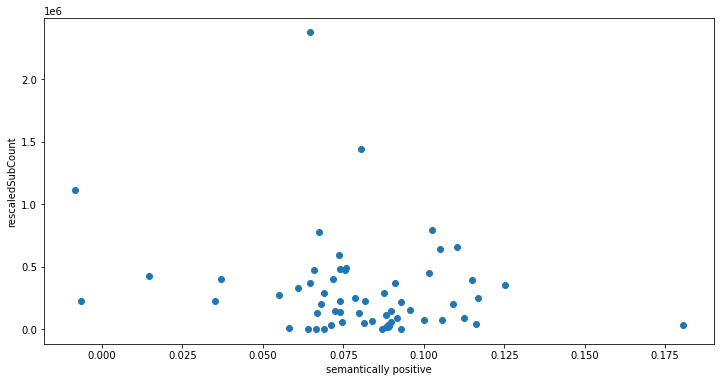

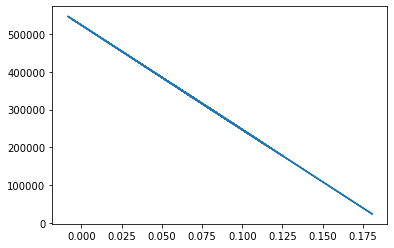

In [26]:
print(len(channelHolisticInfoDf), len(subsPerYearSinceFirstUpload), len(channelName_to_scores))
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
def generate_plot(semantic_df):
    x_name = "semantically positive"
    y_name = "rescaledSubCount"

    tooltip_name = "channelName"
    x= semantic_df['positivityScores']
    y= semantic_df['rescaledSubCount']

    tt = semantic_df[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
    # Plot the average line
    mean_x=np.arange(0,33,1)
    mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
    # mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details["positivityScores"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
generate_plot(semantic_df)

In [27]:
import numpy as np
import pandas as pd
def detect_outlier(data_1):
    outliers=[]
    # threshold=3 means any data with a stdDev> 3 or <-3 is 0.3 of all data. Almost all of the data (99.7%) should be within 3 stddev from the mean
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    index =0
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append((index, y))
        index+=1
    return outliers
print("rescaledSubs outlier:", detect_outlier(subsPerYearSinceFirstUpload))
print("semantic_scores outlier:", detect_outlier(list(channelName_to_scores.values())))

rescaledSubs outlier: [(29, 2376871.2574850298)]
semantic_scores outlier: [(28, -0.008489563758389364), (46, -0.0064570839936609024), (58, 0.18063620848708486)]


In [28]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
semantic_df

,channelName,rescaledSubCount,positivityScores
0,TJ Toons,143883.228840,0.072513
1,Alex's Corner,154790.575916,0.095571
2,RushLight Invader,30987.388496,0.088850
3,ChillyPanda,34241.159136,0.071250
4,Recreyo,222003.577818,0.035146
...,...,...,...
56,Jacadamia,14926.754832,0.088799
57,grgikau,2231.361829,0.069127
58,Laddi,35002.564103,0.180636
59,The French Pineapple,6562.435233,0.057982


In [32]:
import scipy
copy_without_rescaledSubs_outlier = semantic_df.drop(29)
copy_without_semantic_outlier = semantic_df.drop([28, 46, 58])
copy_without_rescaledSubs_and_semantic_outlier = semantic_df.drop([29, 28, 46, 58])
semantic_df_copy_without_rescaledSubs_outlier = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_rescaledSubs_outlier.to_dict())))
semantic_df_copy_without_semantic_outlier = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_semantic_outlier.to_dict())))
semantic_df_copy_without_rescaledSubs_and_semantic_outlier = pd.DataFrame.from_dict(json.loads(json.dumps(copy_without_rescaledSubs_and_semantic_outlier.to_dict())))

# generate_plot(semantic_df_copy_without_rescaledSubs_outlier)
# generate_plot(semantic_df_copy_without_semantic_outlier)
# generate_plot(semantic_df_copy_without_rescaledSubs_and_semantic_outlier)
x_name = "rescaledSubCount"
y_name = "positivityScores"
print(scipy.stats.spearmanr(semantic_df[x_name], semantic_df[y_name], axis=0))
print(scipy.stats.spearmanr(semantic_df_copy_without_semantic_outlier[x_name], semantic_df_copy_without_semantic_outlier[y_name], axis=0))
print(scipy.stats.spearmanr(semantic_df_copy_without_rescaledSubs_outlier[x_name], semantic_df_copy_without_rescaledSubs_outlier[y_name], axis=0))
print(scipy.stats.spearmanr(semantic_df_copy_without_rescaledSubs_and_semantic_outlier[x_name], semantic_df_copy_without_rescaledSubs_and_semantic_outlier[y_name], axis=0))


SpearmanrResult(correlation=-0.14891591750396613, pvalue=0.2520396273472426)
SpearmanrResult(correlation=-0.0781629702543911, pvalue=0.5597542784027358)
SpearmanrResult(correlation=-0.11892192275632123, pvalue=0.3654628101569807)
SpearmanrResult(correlation=-0.04161265232045632, pvalue=0.7585834454580391)


The p (or probability) value obtained from the calculator is a measure of how likely or probable it is that any observed correlation is due to chance. P-values range between 0 (0%) and 1 (100%). A p-value close to 1 suggests no correlation other than due to chance and that your null hypothesis assumption is correct.

So how exactly strong is the correlation? 
We use r-values
https://www.researchgate.net/post/What-does-R-square-Adjusted-R-and-R-indicate-in-terms-of-Multiple-Regression-Analysis

Simply put, R is the correlation between the predicted values and the observed values of Y. R square is the square of this coefficient and indicates the percentage of variation explained by your regression line out of the total variation. This value tends to increase as you include additional predictors in the model. Thus, one can artificially get higher  R square by increasing the number of Xs in the model. To penalize this effect, adjusted R square is used. When you compare models with their complexity, you should then rely on Adj R square. Predicted R square is another measure which addresses the issue of overfitting the data  and explain the prediction power for future observations. 

In [33]:
import numpy as np
import scipy.stats
x= 'rescaledSubCount'	
y= 'positivityScores'
result = scipy.stats.linregress(semantic_df[x], semantic_df[y])
result_no_rescaled_outlier = scipy.stats.linregress(semantic_df_copy_without_rescaledSubs_outlier[x], semantic_df_copy_without_rescaledSubs_outlier[y])
result_no_semantic_outlier = scipy.stats.linregress(semantic_df_copy_without_semantic_outlier[x], semantic_df_copy_without_semantic_outlier[y])
result_no_rescaled_and_semantic_outliers = scipy.stats.linregress(semantic_df_copy_without_rescaledSubs_and_semantic_outlier[x], semantic_df_copy_without_rescaledSubs_and_semantic_outlier[y])

print('rvalue:{}, pvalue:{}'.format(result.rvalue, result.pvalue))
print("removed positivity outlier: ", 'rvalue:{}, pvalue:{}'.format(result_no_rescaled_outlier.rvalue, result_no_rescaled_outlier.pvalue))
print("removed subCount outlier: ", 'rvalue:{}, pvalue:{}'.format(result_no_semantic_outlier.rvalue, result_no_rescaled_outlier.pvalue))
print("removed both subCount and positivity outliers: ", 'rvalue:{}, pvalue:{}'.format(result_no_rescaled_and_semantic_outliers.rvalue, result_no_rescaled_and_semantic_outliers.pvalue))

rvalue:-0.2063601160418737, pvalue:0.11057642066491054
removed positivity outlier:  rvalue:-0.21929188596567528, pvalue:0.09228714538082097
removed subCount outlier:  rvalue:-0.1018008971256528, pvalue:0.09228714538082097
removed both subCount and positivity outliers:  rvalue:-0.03194011563949614, pvalue:0.8135410729185382


The p (or probability) value obtained from the calculator is a measure of how likely or probable it is that any observed correlation is due to chance. P-values range between 0 (0%) and 1 (100%). A p-value close to 1 suggests no correlation other than due to chance and that your null hypothesis assumption is correct.

Tbh, the results kind of suck. 
Need to test the null hypothesis
The null hypothesis is a typical statistical theory which suggests that **no statistical relationship and significance exists in a set of given single observed variable**, between two sets of observed data and measured phenomena.

In [44]:
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

    return results

for i in range(5):
    print(adjR(semantic_df[x], semantic_df[y], i))

{'r_squared': 0.0}
{'r_squared': 0.026357116094388733}
{'r_squared': 0.021085839535675555}
{'r_squared': 0.004169388446726208}
{'r_squared': -0.01100854043721533}


! https://opentextbc.ca/researchmethods/chapter/understanding-null-hypothesis-testing/
A crucial step in null hypothesis testing is finding the likelihood of the sample result if the null hypothesis were true. This probability is called the p value. A low p value means that the sample result would be unlikely if the null hypothesis were true and leads to the rejection of the null hypothesis. A high p value means that the sample result would be likely if the null hypothesis were true and leads to the retention of the null hypothesis. But how low must the p value be before the sample result is considered unlikely enough to reject the null hypothesis? In null hypothesis testing, this criterion is called α (alpha) and is almost always set to .05. If there is less than a 5% chance of a result as extreme as the sample result if the null hypothesis were true, then the null hypothesis is rejected. When this happens, the result is said to be statistically significant. If there is greater than a 5% chance of a result as extreme as the sample result when the null hypothesis is true, then the null hypothesis is retained. This does not necessarily mean that the researcher accepts the null hypothesis as true—only that there is not currently enough evidence to conclude that it is true. Researchers often use the expression “fail to reject the null hypothesis” rather than “retain the null hypothesis,” but they never use the expression “accept the null hypothesis.”

> The Misunderstood p Value

> The p value is one of the most misunderstood quantities in psychological research (Cohen, 1994)[1]. Even professional researchers misinterpret it, and it is not unusual for such misinterpretations to appear in statistics textbooks!

> The most common misinterpretation is that the p value is the probability that the null hypothesis is true—that the sample result occurred by chance. For example, a misguided researcher might say that because the p value is .02, there is only a 2% chance that the result is due to chance and a 98% chance that it reflects a real relationship in the population. But this is incorrect. The p value is really the probability of a result at least as extreme as the sample result if the null hypothesis were true. So a p value of .02 means that if the null hypothesis were true, a sample result this extreme would occur only 2% of the time.

> You can avoid this misunderstanding by remembering that the p value is not the probability that any particular hypothesis is true or false. Instead, it is the probability of obtaining the sample result if the null hypothesis were true.

I need a z-statistic or a t-statistic.
What the f are those?
    A z-score, or z-statistic, is a number representing how many standard deviations above or below the mean population the score derived from a z-test is. Essentially, it is a numerical measurement that describes a value's relationship to the mean of a group of values.

It's the same thing as a z-score, I guess. So calculate and plot the z-score? and then what?

ok. too complicated.

I talked with my sister who just woke up for some suggestions. 

"Just square or log it"

"But I want to either prove or disprove that there is no correlation."

After a lengthy discussion of what p-values are, how to find causation between variables, what we wanted to eat for lunch and dinner, I googled a couple of things which eventually led me to this stackexchange post: https://stats.stackexchange.com/questions/99874/how-to-show-that-there-is-no-relationship

In [ ]:
from ace.samples import wang04
x, y = wang04.build_sample_ace_problem_wang04(N=200)
print(len(x), len(x[0]), len(y))
from ace import model
myace = model.Model()
myace.build_model_from_xy(x, y)
myace.eval([0.1, 0.2, 0.5, 0.3, 0.5])

In [ ]:
from ace import model
x= 'rescaledSubCount'	
y= 'positivityScores'
myace = model.Model()
myace.build_model_from_xy([semantic_df[x]], semantic_df[y])
myace.eval([0.0001])

In [19]:
import text2emotion as te
import glob

channelId_to_vidId_to_emotion = {} #{channelId:[vidId: {emotions}, vidId: {emotions}]}
for channelId in glob.glob("*/"):
    channelId_to_vidId_to_emotion[channelId] = []
    for textfile in glob.glob(channelId+"txt/*.txt"):
        print(textfile)
        data=''
        with open(textfile, 'r') as f:
            data = f.readlines()
        removeDuplicate = [i for n, i in enumerate(data) if i not in data[:n]]
        stringOfContent = ("").join(removeDuplicate)
        emotionDict = te.get_emotion("".join(stringOfContent) )
        channelId_to_vidId_to_emotion[channelId].append({textfile.split('/')[-1].split('.')[0]: emotionDict})



UCY6Ij8zOds0WJEeqCLOnqOQ/txt/JGd-tZ-5Wvk.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/O4IxMlqY3hI.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/Jt0-avGfah0.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/qIZiKkdt1G4.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/5aDOp3jOKxw.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/8GXvhbww7NE.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/95Y2w_bdT3E.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/hUdc7nP3aoM.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/-x8JIdHnRo4.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/6Ten2oCgnb0.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/5Ot3hCVHW5s.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/XMCho5i0Gx8.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/IogIFWPEA-k.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/L9PGsXv7RGU.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/NyvHh4GEAn4.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/ah1Yzcc_q3M.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/F94sRf1h1c4.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/qbR3jtksrfg.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/2Rpf2FJMh14.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/kHioXgBZYLU.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/ZbJpIgJ-0js.txt
UCY6Ij8zOds0WJEeqCLOnqOQ/txt/pfdEzw4yi9c.txt
UCY6Ij8zOd

In [21]:
import json
with open ('channelId_to_vidId_to_emotion.json', 'w') as f:
    json.dump(channelId_to_vidId_to_emotion, f)

Actually, I don't think using text2emotion really is worth. They use Vader as well- except the four of the contributors seem to be the ones who made random decisions on what words denote happiness, sadness, fear, surprise, etc. It doesn't seem to be used widely in the data science community- probably doesn't have a track record yet. 